# Analysis part

In [2]:
library(ggplot2)
library(quantreg)


df = read.csv('merged_datasets_final/merged_Machamp_1st_Edition__Holo_1999_Base_Set.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock to returns
df$adjclosestock_return <- c(NA, diff(log(df$adjclosestock)))

#remove rows with NA in the newly created return columns
df <- na.omit(df)

head(df)

,date,grade5price,grade6price,grade7price,grade8price,grade9price,grade10price,adjclosestock,volume,adjclosebond,stockreturns,bondadjusted,excessreturns,grade5price_return,grade6price_return,grade7price_return,grade8price_return,grade9price_return,grade10price_return,adjclosestock_return
2,2016-10-01,14.00,7.500000,15.000,38.110,60.67667,599.9,2126.15,72915530000,2.589,-0.0194256789,0.02589,-0.127730484,0.000000,0.0000000,0.0000000,0.0000000,-0.32227695,0.000000,-0.0196168370
3,2016-11-01,14.00,7.500000,8.500,38.110,64.21000,599.9,2198.81,88445380000,3.017,0.0341745218,0.03017,-0.131140262,0.000000,0.0000000,-0.5679840,0.0000000,0.05659974,0.000000,0.0336035450
4,2016-12-01,3.25,9.583333,8.500,27.500,38.13800,70.0,2238.83,75344550000,3.063,0.0182007624,0.03063,0.002953827,-1.460402,0.2451225,0.0000000,-0.3262907,-0.52094780,-2.148268,0.0180371113
5,2017-01-01,3.25,9.583333,8.500,15.935,27.00000,70.0,2278.87,70576420000,3.051,0.0178843582,0.03051,0.021802036,0.000000,0.0000000,0.0000000,-0.5456681,-0.34537429,0.000000,0.0177263146
6,2017-02-01,3.25,15.995000,12.005,29.000,40.95250,70.0,2363.64,69260940000,2.968,0.0371981601,0.02968,0.064402414,0.000000,0.5122507,0.3452571,0.5987779,0.41657599,0.000000,0.0365230007
7,2017-03-01,3.25,11.600000,12.005,17.125,72.05000,633.0,2362.72,81664010000,3.018,-0.0003891971,0.03018,-0.017235543,0.000000,-0.3212711,0.0000000,-0.5267564,0.56494746,2.201975,-0.0003892729


## Visualisation

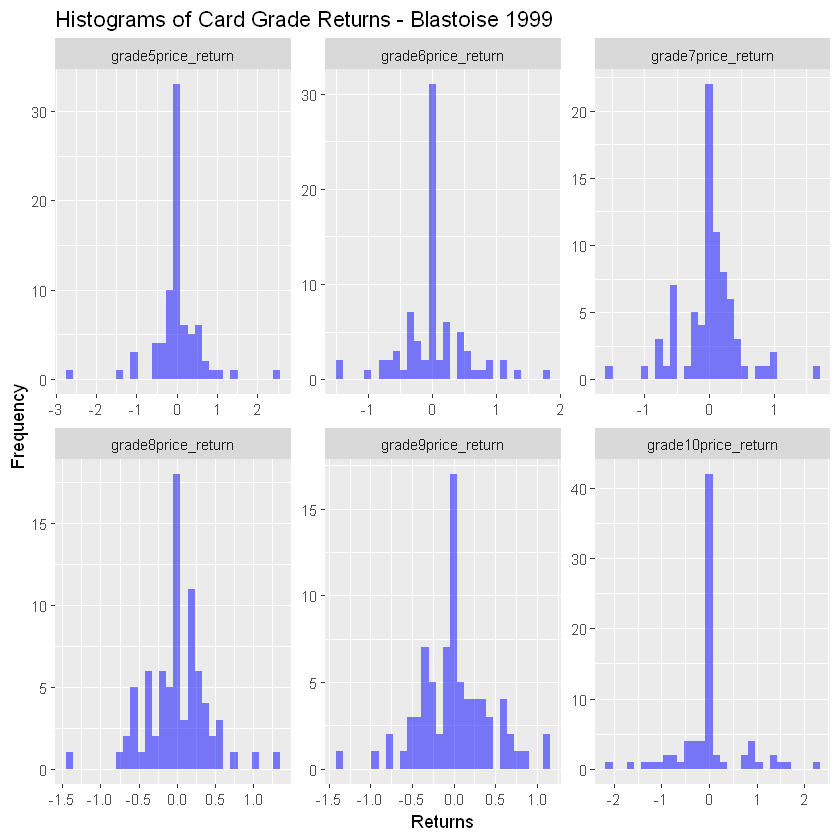

In [3]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

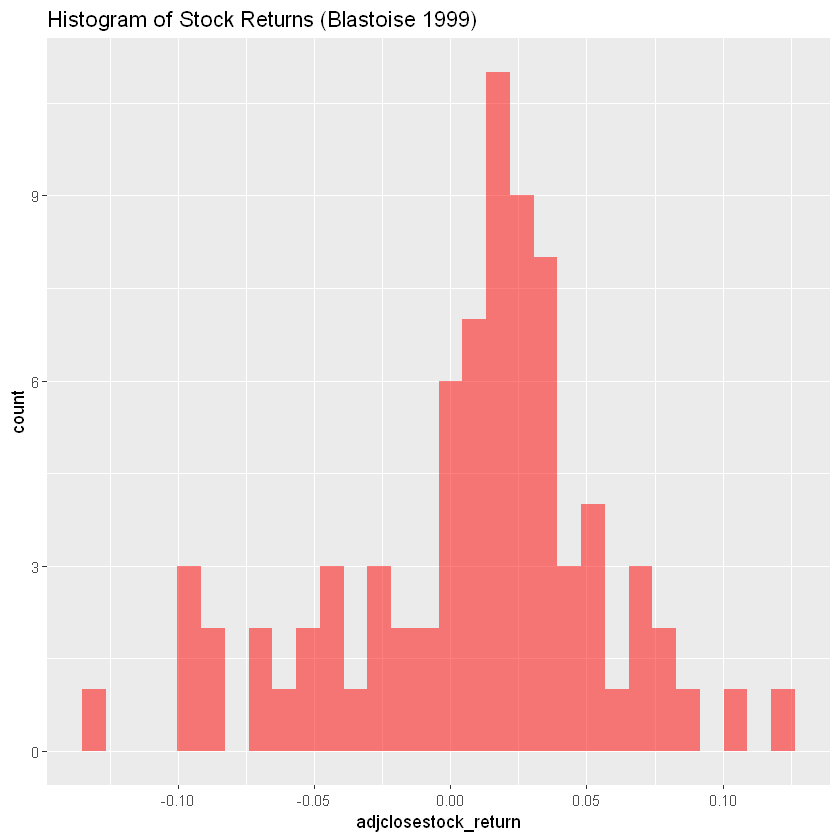

In [4]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

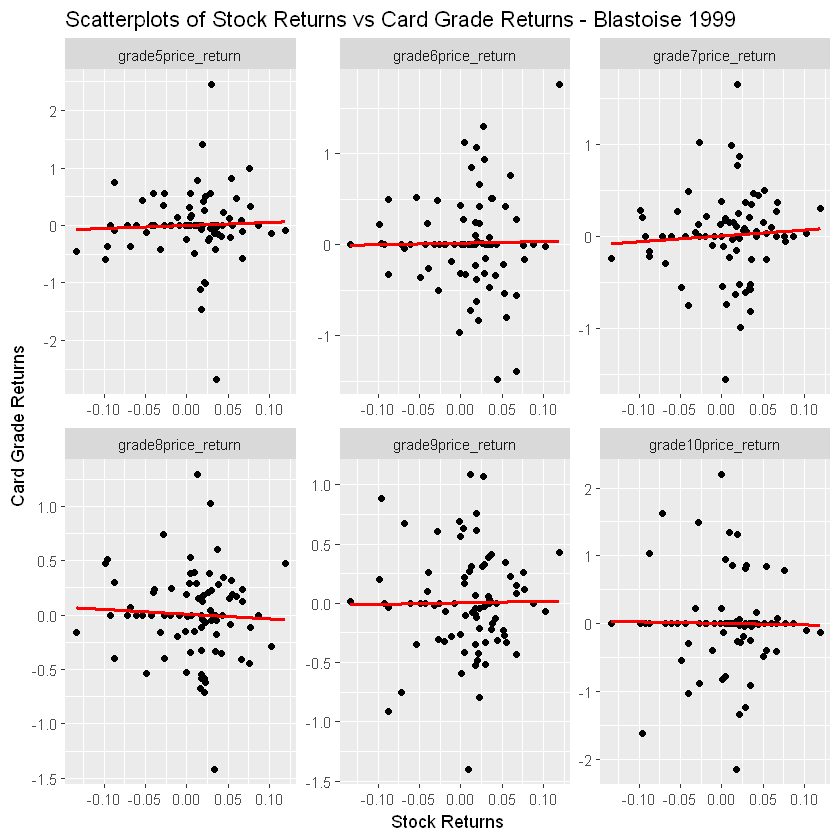

In [5]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestock_return"), measure.vars = grade_returns)

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestock_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Models

### OLS

In [6]:
#OLS
ols_models <- list()
for(grade_return in grade_returns) {
  ols_models[[grade_return]] <- lm(get(grade_return) ~ adjclosestock_return, data = df)
}

#print summary of each OLS model
for(grade_return in grade_returns) {
  print(paste("Summary of model for:", grade_return))
  print(summary(ols_models[[grade_return]]))
}


[1] "Summary of model for: grade5price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.70186 -0.17220 -0.00668  0.15706  2.43767 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)
(Intercept)          -0.0009804  0.0689101  -0.014    0.989
adjclosestock_return  0.5266876  1.4163165   0.372    0.711

Residual standard error: 0.6036 on 77 degrees of freedom
Multiple R-squared:  0.001793,	Adjusted R-squared:  -0.01117 
F-statistic: 0.1383 on 1 and 77 DF,  p-value: 0.711

[1] "Summary of model for: grade6price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50484 -0.24624 -0.01737  0.22539  1.71942 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.01654    0.06017   0.275    0.784
adjclosestock_return  0.17252    1.23675   0.139    0

### Quantile regression

In [7]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = 0.1)  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  print(paste("Summary of quantile regression model for:", grade_return))
  print(summary(quantile_models[[grade_return]]))
}


[1] "Summary of quantile regression model for: grade5price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.49165     -0.92543 -0.28510
adjclosestock_return -0.22027     -1.00926  3.30953
[1] "Summary of quantile regression model for: grade6price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.56799     -0.72856 -0.37294
adjclosestock_return -4.24924     -5.88024  0.30718
[1] "Summary of quantile regression model for: grade7price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.56532     -0.74118 -0.47705
adjclosestock_return -0.35475

In [8]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step

#### Results for different quantiles of the grade prices x OLS estimates (red line) 

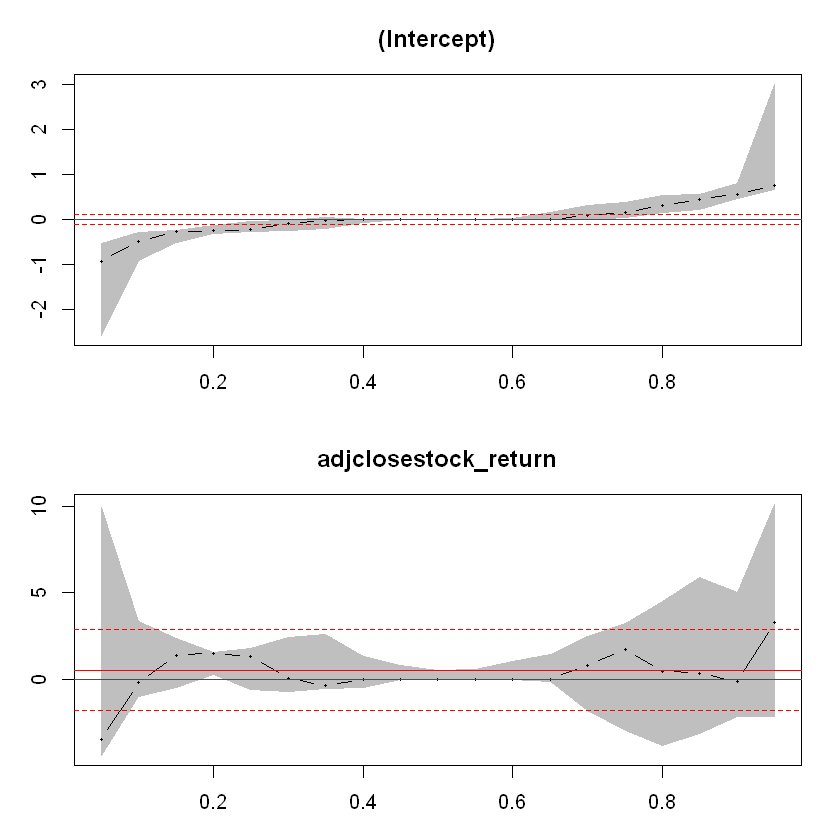

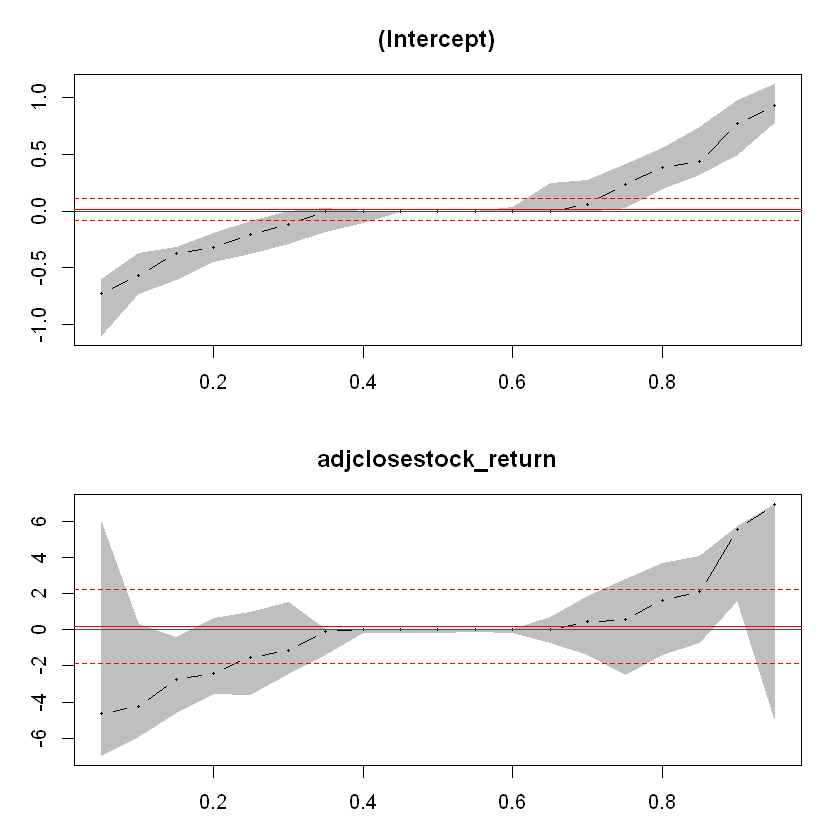

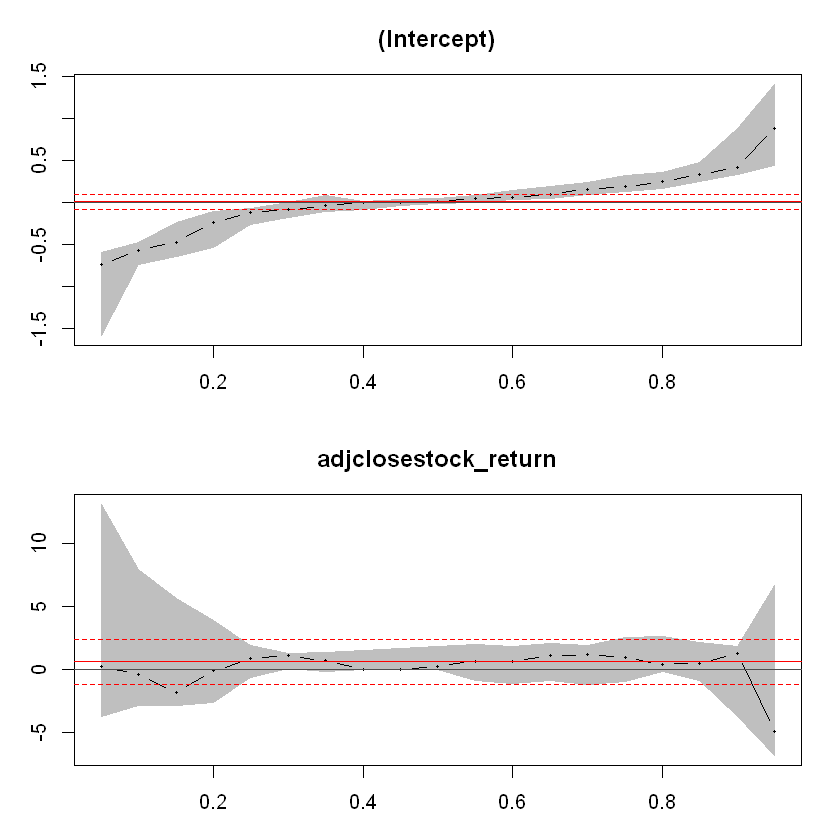

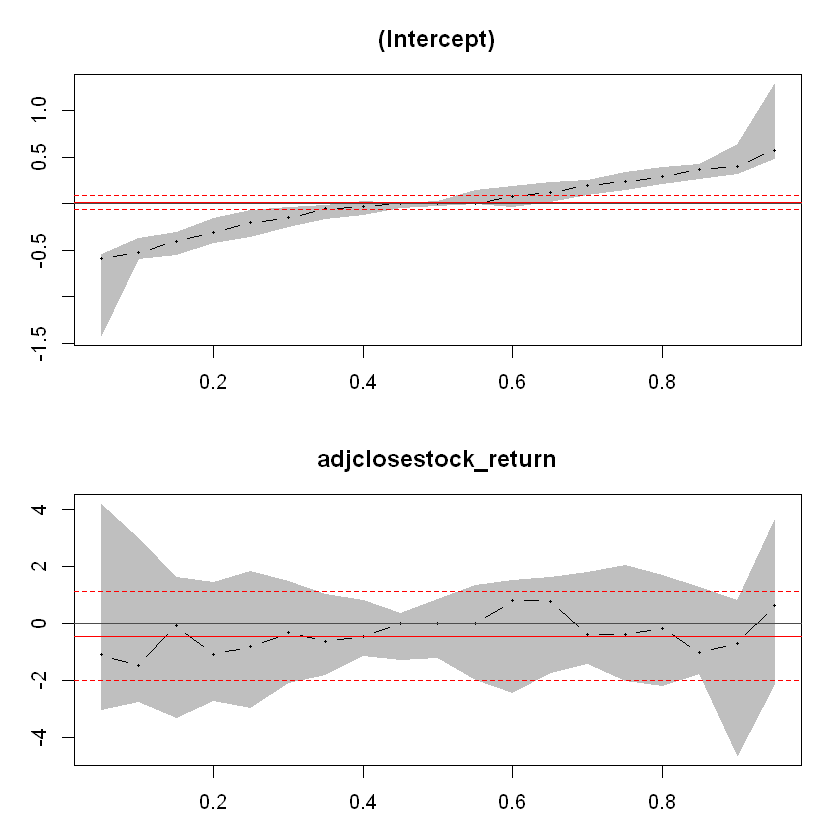

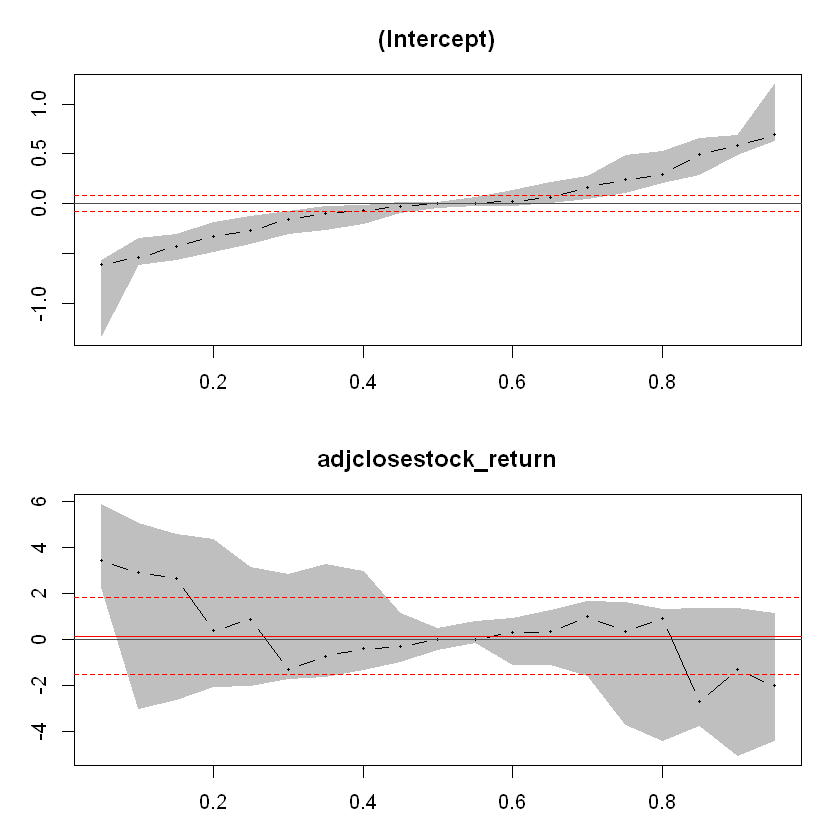

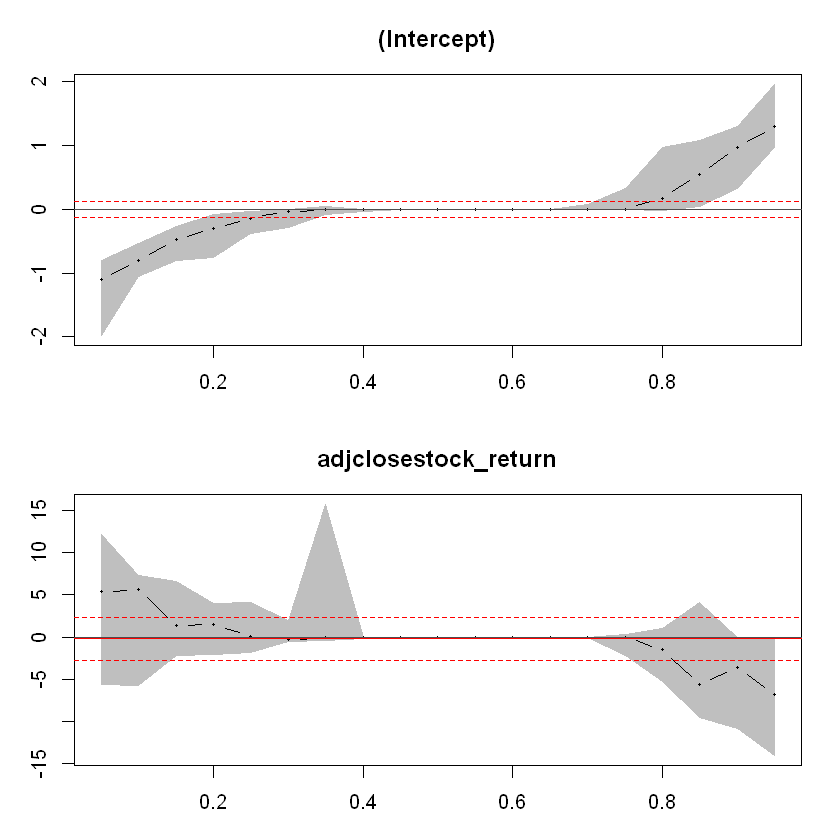

In [9]:

for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
  plot(summary(quantile_models[[grade_return]]))
}